### 캐니 에지
1986년 캐니에 의해 설계된 에지 검출 연산자이다. 현재 가장 널리 사용되며 에지 검출을 최적화 문제로 취급했다.  
다음은 캐니가 제시한 좋은 에지 알고리즘의 세가지 기준이다.
- 최소 오류율 : 거짓 긍정과 거짓 부정이 최소여야 한다. 즉, 없는 에지가 생성되거나 있는 에지를 못 찾는 경우를 최소로 유지해야 한다.
- 위치 정확도 : 검출된 에지는 실제 에지의 위치와 가급적 가까워야 한다.
- 에지 두께 : 실제 에지에 해당하는 곳에는 한 두께의 에지만 생성해야 한다.

하지만 위 조건을 모두 만족하는 일반적인 연산자를 찾아내는 것은 불가능한 일이다. 따라서 1차원 계단 에지에 화이트 잡음이 첨가된 상활을 가정해 최적화 작업을 했다. 그 결과 가우시안에 1차 미분을 적용한 연산자가 최적임을 수학적으로 증명했다. 하지만 1차원에서 도출된 결과를 2차원으로 확장하려면 gradient 방향을 찾아내 그 방향으로 미분을 해야 한다. 이 과정을 소벨이나 프레윗같은 마스크를 이용해 gradient 방향을 구하는 것으로 근사화할 수 있고, 이때 발생하는 오류는 허용할 수 있는 범위에 있다는 것도 증명했다. 이렇게 구한 에지 영상은 에지가 두껍기 때문에 얇게 바꾸는 비최대 억제라는 단계를 추가했다. 마지막으로 거짓 긍정 에지를 제거하는 이력 임계값 단계를 적용한다.

### 비최대 억제와 이력 임계값
비최대 억제(non-maximum suppression)은 자신의 이웃보다 크지 않은 화소를 에지가 아닌 것으로 결정한다.
각각의 이웃은 다음과 같다.
- 에지 방향 0 : 위,아래
- 에지 방향 1 : 북동,남서
- 에지 방향 2 : 왼쪽,오른쪽
- 에지 방향 3 : 북서, 남동

이 방식을 사용하면 에지가 아닌데 에지로 판정되는 거짓 긍정의 케이스가 생긴다. 가장 간단한 방법은 임계값을 설정해 임계값보다 낮은 값을 거짓으로 하는 것이다.  
임계값을 한번만 설정하면 에지인데 에지가 아닌것으로 판단되는 거짓 부정의 케이스가 생길수도 있기 때문에 높은 임계값으로 걸러진 영상에서 각 이웃 픽셀을 2~3배 낮은 임계값으로 한번더 확인한다.  
이렇게 두 개의 임계값을 쓰는 방식을 이력 임계값(Hysteresis thresholding) 방법이라고 한다.

### 코드구현
다음의 사진으로 구현해본다.

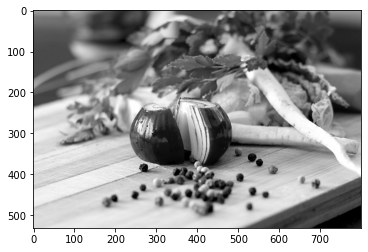

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('./data/food.jpg',cv2.IMREAD_GRAYSCALE)

plt.imshow(img,cmap='gray')
plt.show()

컨볼루션 연산은 지난번에 사용한 것과 동일하다.

In [2]:
def im2col(input_data, filter_h, filter_w):
    H, W, C = input_data.shape

    u_pad_h = (filter_h-1)//2
    d_pad_h = (filter_h-1)//2
    l_pad_w = (filter_w-1)//2
    r_pad_w = (filter_w-1)//2
    if (filter_h-1) %2 ==1:
        u_pad_h +=1
    if (filter_w-1)%2 ==1:
        l_pad_w +=1
    input_data = cv2.copyMakeBorder(input_data, u_pad_h, d_pad_h, l_pad_w, r_pad_w, cv2.BORDER_REPLICATE)
    if C==1:
        input_data= np.expand_dims(input_data,-1)
    img = np.transpose(input_data,(2,0,1))
    col = np.zeros(( C, filter_h, filter_w, H, W))

    for y in range(filter_h):
        y_max = y + H
        for x in range(filter_w):
            x_max = x + W
            col[:, y, x, :, :] = img[:, y:y_max:1, x:x_max:1]

    col = np.transpose(col,(0,3,4,1,2)).reshape(C*H*W, -1)

    return col

def conv(img,filter):
    filter_h ,filter_w = filter.shape
    if len(img.shape) ==3:
        img_h,img_w,c = img.shape
    elif len(img.shape)==2:
        img_h,img_w = img.shape
        c=1
        img = np.expand_dims(img,-1)
    else:
        print("Length of image shape must over 2")
        return
    col = im2col(img,filter_h,filter_w)
    col_filetr = filter.reshape((1,-1)).T
    out = np.dot(col, col_filetr)
    return np.transpose(out.reshape((c, img_h, img_w)),(1, 2,0))

가우시안 필터를 만드는 연산 역시 지난번과 동일하다.

In [3]:
def gaussian2d(x,y,sigma):
    x2 = x**2
    y2 = y**2
    sigma2 = sigma**2
    return (1/(2*np.pi*sigma2))*np.exp(-1*((x2+y2)/(2*sigma2)))

def make_gaussian(sigma):
    size = int(sigma * 6)
    if size % 2 == 0:
        size += 1
    aran = np.arange(-1 * (size // 2), size // 2 + 1)
    XX, YY = np.meshgrid(aran, aran)
    return gaussian2d(XX, YY, sigma)

소벨 연산의 경우 에지 강도는 지난번과 동일하다. 다만 에지 방향을 저번에 구하지 않았었는데 arctan(dy_image,dx_image)를 하면 그레디언트의 방향을 알 수 있다. 그레디언트의 방향과 에지 방향은 서로 직교하므로 90을 더해주고 0~3과 4~7은 동일하므로 0이하의 값에 180을 더했다.

In [4]:
def direction_quantization(atan):
    ret = np.where(np.logical_and(atan>=22.5,atan<67.5),7,4)
    ret = np.where(np.logical_and(atan >= 67.5, atan < 111.5), 6, ret)
    ret = np.where(np.logical_and(atan >= 111.5, atan < 157.5), 5, ret)
    return ret

def sobel(img):
    sobel_mask_y = np.array([[-1, -2, -1],
                             [0, 0, 0],
                             [1, 2, 1]])

    sobel_mask_x = np.array([[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]])

    dy_image = conv(img, sobel_mask_y).squeeze()
    dx_image = conv(img, sobel_mask_x).squeeze()
    dy_image[0, :] = dy_image[-1, :] = 0
    dx_image[:, 0] = dx_image[:, -1] = 0

    Sobel = np.uint8(np.sqrt((dy_image ** 2) + (dx_image ** 2)))
    atan = np.arctan2(dy_image, dx_image) / np.pi * 180
    atan += 90
    atan[atan > 180] = 360 - atan[atan > 180]
    atan[atan < 0] += 180
    direc = direction_quantization(atan)

    return Sobel, direc

소벨 필터를 거친 이미지에서 에지의 방향에 따라 각각의 이웃보다 큰지 확인하기 위해서 다음과 같이 함수를 작성했다.

In [5]:
def non_maximum_suppression(img,direction):
    e_img = np.pad(img[:, 1:], ((0, 0), (0, 1)),constant_values=255)
    w_img = np.pad(img[:, :-1], ((0, 0), (1, 0)),constant_values=255)
    n_img = np.pad(img[:-1, :], ((1, 0), (0, 0)),constant_values=255)
    s_img = np.pad(img[1:, :], ((0, 1), (0, 0)),constant_values=255)
    se_img = np.pad(s_img[:, 1:], ((0, 0), (0, 1)),constant_values=255)
    ne_img = np.pad(n_img[:, 1:], ((0, 0), (0, 1)),constant_values=255)
    sw_img = np.pad(s_img[:, :-1], ((0, 0), (1, 0)),constant_values=255)
    nw_img = np.pad(n_img[:, :-1], ((0, 0), (1, 0)),constant_values=255)

    ret = np.where(direction == 4, np.logical_and(img >= n_img, img >= s_img), False)
    ret = np.where(direction == 5, np.logical_and(img >= ne_img, img >= sw_img), ret)
    ret = np.where(direction == 6, np.logical_and(img >= e_img, img >= w_img), ret)
    ret = np.where(direction == 7, np.logical_and(img >= nw_img, img >= se_img), ret)
    return ret

이제 케니연산자의 전체 함수는 다음과 같다.

In [6]:
def neighbor(img):
    img = np.uint8(img)
    e_img = np.pad(img[:, 1:], ((0, 0), (0, 1)))
    w_img = np.pad(img[:, :-1], ((0, 0), (1, 0)))
    n_img = np.pad(img[:-1, :], ((1, 0), (0, 0)))
    s_img = np.pad(img[1:, :], ((0, 1), (0, 0)))
    se_img = np.pad(s_img[:, 1:], ((0, 0), (0, 1)))
    ne_img = np.pad(n_img[:, 1:], ((0, 0), (0, 1)))
    sw_img = np.pad(s_img[:, :-1], ((0, 0), (1, 0)))
    nw_img = np.pad(n_img[:, :-1], ((0, 0), (1, 0)))
    return (w_img+e_img+n_img+s_img+sw_img+nw_img+se_img+ne_img+img)>0

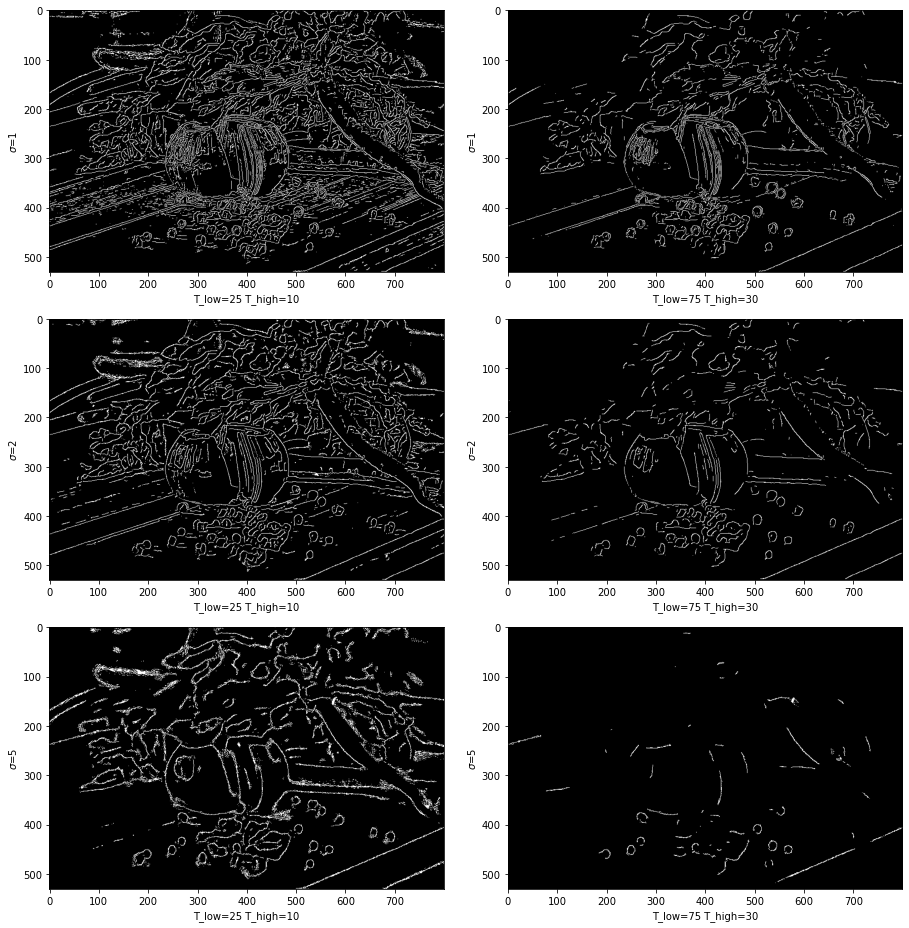

In [7]:
gaussian_value=[1,2,5]
thresholds = [[10,25],[30,75]]
fig = plt.figure(figsize=(13,13))
for i,sigma in enumerate(gaussian_value):
    for j,ths in enumerate(thresholds):
        plt.subplot(321+i*2+j)
        gau_filter = make_gaussian(sigma)
        gau = np.uint8(conv(img, gau_filter).squeeze())
        canny_img = canny(gau,ths[1],ths[0])
        plt.imshow(canny_img, cmap='gray')
        plt.ylabel('$\sigma$={}'.format(sigma))
        plt.xlabel('T_low={} T_high={}'.format(ths[1],ths[0]))
fig.tight_layout()
plt.show()

sigma 값이 커질수록 디테일이 작아지며 임계값이 높을 때 검출되는 에지의 숫자가 줄어든다.

### OpenCV
opencv 같은 경우 가우시안과 케니를 다음과 같이 사용하면 된다.  
직접 구현한 것과는 결과에서 차이가 발생한다.

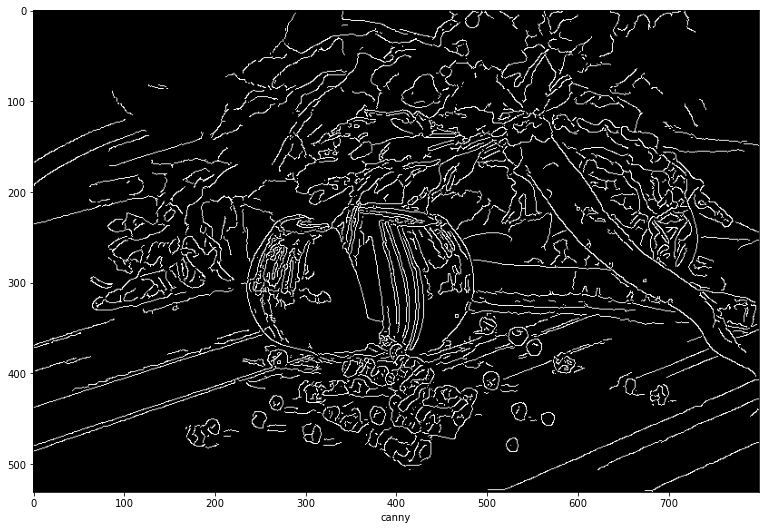

In [16]:
cv_gau = cv2.GaussianBlur(img,(7,7),1)
plt.figure(figsize=(13,13))
cv_canny = cv2.Canny(cv_gau,30,30*2.5)
plt.imshow(cv_canny,cmap='gray')
plt.xlabel("canny")
plt.show()